# Nightlights Generator

---
*Christian Johannes Meyer ([christian.meyer@eui.eu](christian.meyer@eui.eu)) and Espen Beer Prydz ([eprydz@worldbank.org](eprydz@worldbank.org))*
 
Sept 2, 2016

---

This notebook uses [Google Earth Engine](https://earthengine.google.com) to calculate total nightlights over all World Bank countries and economies, using shapefiles of the World Bank map unit. Learn more about World Bank country classifications [here](https://datahelpdesk.worldbank.org/knowledgebase/articles/906519). The resulting CSV file to saved in Google Drive. A second Jupyter notebook is used to reshape the CSV file and add basic country indicators. 

We use data on stable lights of the [NOAA DMSP-OLS Nighttime Lights Time Series](https://code.earthengine.google.com/dataset/NOAA/DMSP-OLS/NIGHTTIME_LIGHTS). 

Before running this notebook, you need to install the Google Earth Engine Python API. The package lives on [Github](https://github.com/google/earthengine-api). Google provides detailed instructions on [how to install the client library](https://developers.google.com/earth-engine/python_install#installing-the-client-library) and [how to set up your Google authentication credentials](https://developers.google.com/earth-engine/python_install#setting-up-authentication-credentials). 

---

## 1. Preliminary

In [71]:
%matplotlib inline

#### Import relevant packages

In [72]:
# Bokeh charts
from bokeh.plotting import figure, output_notebook, show
from bokeh.resources import INLINE
output_notebook(resources=INLINE)

Loading BokehJS ...

In [73]:
# Import the Earth Engine Python Package
import ee

# JSON
import json

# Pandas
from pandas import Series, DataFrame
from pandas.io.json import json_normalize
import pandas as pd

# Geopandas
import geopandas as gpd
from geopandas import GeoDataFrame

# Folium for quick visualization on Leaflet map
import folium

# Plotting
import matplotlib.pyplot as plt

# Import other Python packages we need
from geojson import FeatureCollection, Feature, Polygon, Point
from shapely.geometry import shape
import numpy as np
import os, fnmatch, sys, datetime, time, itertools, fiona, string

# Pandas datareader for WDI API access
from pandas_datareader import wb as wdi

#### Initialize Google Earth Engine

In [74]:
ee.Initialize()

#### Parameters

In [75]:
# Define paths to input and output files
CSV_PATH = 'output' 
GEOMETRY_PATH = 'static' 
GEOMETRY_FILE = 'wb_geo_ee.geojson' # World Bank boundaries
COORD_FILE = 'myanmar_markets.csv'


# Source collection or image
SOURCE = 'NOAA/DMSP-OLS/_NIGHTTIME_LIGHTS'

# Settings for EE data
# This should be changed in production
REDUCTION_SCALE = 1000
BUFFER_SCALE = 5000

# Extraction dates
YEAR_START = 1992
YEAR_END = 2015

## 2. Import Geodata

#### Get night lights data from Google Earth Engine

In [76]:
collection = ee.ImageCollection(SOURCE)

Select only stable lights, extract relevant years, and sort for years from beginning of dataset

In [77]:
collection = collection.select('stable_lights').sort('system:time_start').filterDate(str(YEAR_START)+'-01-01', str(YEAR_END)+'-01-01')

#### Import shapefile from World Bank


In [78]:
# Open GeoJSON file as dictionary
wbgeojson = json.load(open(GEOMETRY_PATH + '/' + GEOMETRY_FILE))

# Import all features into FeatureCollection
wbfc = ee.FeatureCollection(wbgeojson['features'])    

# Select regions
regions = wbfc
# regions = wbfc.filterMetadata('ISO_Codes', 'starts_with', 'B');

Display inline as map to check import and coverage

In [79]:
boundarymap = folium.Map([30, 0],zoom_start=1,detect_retina=True,tiles='cartodbpositron')
folium.features.GeoJson(wbgeojson).add_to(boundarymap)
boundarymap

#### Import CSV file with single points (e.g. households)

These functions parse imported points from CSV into a FeatureCollection 

In [117]:
def parsepoints(df):
    features = []
    for index, row in df.iterrows():
        geometry = Point([row["longitude"], row["latitude"]])
        # we can pass other properties we want here
        properties = dict(name=row["name"])
        # [CJM 2016-09-08] NOTE that GEE apparently needs the id to be a string or else throws an internal server error
        feature = Feature(geometry=geometry, properties=properties,id=str(row["id"]))
        features.append(feature)
    return FeatureCollection(features)

Import CSV file and pass to EE FeatureCollection

In [118]:
coordfc = parsepoints(pd.read_csv(GEOMETRY_PATH + '/' + COORD_FILE))
points = ee.FeatureCollection(coordfc['features'])    

Expanding the geometry around the point by given distance


In [119]:
def bufferpoints(feature):
    return feature.buffer(BUFFER_SCALE)

bufferedpoints = points.map(bufferpoints)

Display inline as map to check import and coverage

In [1]:
#boundarymap = folium.Map([20.1538, 95.5],zoom_start=6,detect_retina=True,tiles='cartodbpositron')
#folium.features.GeoJson(coordfc).add_to(boundarymap)
#boundarymap


## 3. Compute Statistics using Google Earth Engine

Each band is called 'stable_lights'.  The function below replaces the band names with image name (contains satellite and year). We then map the function over the FeatureCollection with all images.

In [122]:
def feat2band(image):
    return ee.Image(image).select(['stable_lights'],[ee.Image(image).get('system:index')])

collection = collection.map(feat2band)

This function creates a stacked multiband image. We then iterate this function over each image in the FeatureCollection.

In [22]:
def iterator(current,previous):
    result = ee.Algorithms.If(previous, ee.Image(previous).addBands(current), current)
    return result

img_stack = collection.iterate(iterator,ee.Image())

#### Extract data interactively from EE server

Countries...

In [125]:
mapped_results = ee.Image(img_stack).slice(1).reduceRegions(regions, ee.Reducer.sum(), REDUCTION_SCALE).getInfo()

... and single coordinates (buffered)

In [126]:
mapped_results_points = ee.Image(img_stack).slice(1).reduceRegions(points, ee.Reducer.sum(), REDUCTION_SCALE).getInfo()

In [127]:
def fc2df(fc):
    # Convert a FeatureCollection into a pandas DataFrame
   
    # Features is a list of dict with the output
    features = fc['features']

    dictarr = []
      
    for f in features:
        # Store all attributes in a dict
        attr = f['properties']
        dictarr.append(attr)
       
    df = DataFrame(dictarr)
    return df

In [128]:
ee_data_df = fc2df(mapped_results)

Wrangle EE data into better shape

In [129]:
ee_data_df = pd.wide_to_long(ee_data_df, 'F', i='Name',j='feature')
ee_data_df = ee_data_df.reset_index(level=['feature'])

Extract satellite numbers and years, add source information

In [130]:
ee_data_df['feature'] = ee_data_df['feature'].astype(str)
ee_data_df['sat'] = ee_data_df['feature'].str[:2]
ee_data_df['year'] = ee_data_df['feature'].str[-4:]
ee_data_df['ee_source'] = SOURCE
ee_data_df['ee_reductionscale'] = REDUCTION_SCALE

Clean up

In [131]:
# Reset index
ee_data_df = ee_data_df.reset_index()

# lower case column names
ee_data_df.columns = map(string.lower, ee_data_df.columns) 

# Set index again
ee_data_df = ee_data_df.set_index(['name','year','sat'])

# Sort
ee_data_df.sort_index(inplace=True)

# Rename columns for clarity
ee_data_df = ee_data_df.rename(columns={'f': 'ee_nightlights_sum', 'iso_codes':'iso3c'})

Export as CSV

In [132]:
ee_data_df.to_csv(CSV_PATH + '/OpenEarth_Nightlights_byWBGeometry_Interactive.csv', sep=',', encoding='utf-8')

## 4. Add Basic Indicators and Metadata from WDI


Extract country metadata from WDI

In [133]:
wdi_meta_df = wdi.get_countries()
wdi_meta_df.rename(columns = {'name':'country'}, inplace = True)

Query a few indicators from WDI

In [134]:
wdi_indicators = ['SP.POP.TOTL', 'NY.GDP.PCAP.CD', 'NY.GNP.PCAP.CD', 'NY.GNP.PCAP.PP.CD','NY.GDP.PCAP.KD','NY.GDP.PCAP.PP.KD']
wdi_data_df = wdi.download(indicator=wdi_indicators, country='all', start=YEAR_START, end=YEAR_END).dropna().reset_index()

Merge data extracted from WDI API with WBI metadata and clean up column names

In [135]:
wdi_df = pd.merge(wdi_data_df,wdi_meta_df, how='outer', on='country')
wdi_df.columns = map(string.lower, wdi_df.columns) 

#### Group EE data
We first need to aggregate night lights data from EE by iso3c, since some countries have several geometries in the WB GeoJSON file. We sum up lights by country.

In [136]:
ee_df_grouped = ee_data_df.reset_index().set_index(['iso3c','names','year','sat'])
ee_df_grouped.sort_index(inplace=True)
ee_df_grouped = ee_df_grouped.sum(level=['iso3c','year','sat'])[['ee_nightlights_sum']].reset_index()

#### Merge grouped EE data with WDI data
For illustrative purposes, we use the intersection of keys from both frames (as opposed to keys from only WDI, only from EE, or the union).

In [137]:
df = pd.merge(wdi_df, ee_data_df.reset_index(), how='inner', on=['iso3c','year']).set_index(['iso3c','year','sat'])
df.sort_index(inplace=True)

Export to CSV

In [138]:
df.to_csv(CSV_PATH + '/OpenEarth_Nightlights_byWBiso3c_Interactive.csv', sep=',', encoding='utf-8')

## 5. Illlustrating Basic Analysis

Collapse dataset to country/year level by averaging across satellites

In [139]:
df = pd.merge(wdi_df, df.mean(level=['iso3c','year'])[['ee_nightlights_sum']].reset_index(), how='right', on=['iso3c','year']).set_index(['iso3c','year'])

In [140]:
# nightlights per capita
df['ee_nightlights_pc'] = df[['ee_nightlights_sum']].div(df['sp.pop.totl'], axis=0)

# take logs
df['ln_ee_nightlights_pc'] = np.log(df['ee_nightlights_pc'])
df['ln_nygdppcapppkdpc'] = np.log(df['ny.gdp.pcap.pp.kd'])

# Keep only 2013
df2013 = df.reset_index()
df2013 = df2013.loc[df2013['year'] == '2013']

# Drop Cyprus
df2013 = df2013[df2013['iso3c'] != "CYP"]

Plot scatter of 2013 log GPD per capita vs. log lights per capita

Plotting variables

In [141]:
ylab = 'Log Night Lights per Capita'
xlab = 'Log GDP per Capita, PPP (constant 2011 international $)'
title = 'National Accounts vs. Lights (2013)'

#### Option 1: Matplotlib

<function matplotlib.pyplot.scatter>

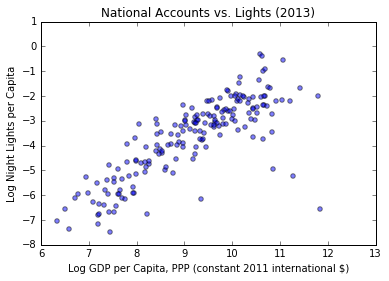

In [142]:
plt.scatter(df2013['ln_nygdppcapppkdpc'],df2013['ln_ee_nightlights_pc'], alpha=0.5)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.title(title)
plt.scatter

#### Option 2: Bokeh

In [143]:
# Quick fix for https://github.com/bokeh/bokeh/issues/4987
import bokeh.io
print(bokeh.io._nb_loaded)
bokeh.io._nb_loaded=True

False


In [144]:
from bokeh.charts import Scatter, output_file, show

In [145]:
# Initialize chart
p = Scatter(df2013[['ln_nygdppcapppkdpc','ln_ee_nightlights_pc','region']], x='ln_nygdppcapppkdpc', y='ln_ee_nightlights_pc', color='region',
            title=title, legend="top_left",
            xlabel=xlab, ylabel=ylab)

# Export HTML
output_file("Nightlights_Scatter.html")

# Show inline in Jupyter notebook
show(p)